In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import csv
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
plt.style.use('bmh')
color_maps = [cm.tab10, cm.Set1, cm.Dark2]

In [2]:
def r_squared(coef, x, y):
    yhat = coef(x)
    ybar = np.sum(y)/y.shape[0]
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return ssreg/sstot

def confidence_band(x):
    return x.std()*np.sqrt(1/x.shape[0] + (x - x.mean())**2 / np.sum((x - x.mean())**2))

def get_latex_string(regression):
    string = "$"
    for i in range(len(regression)+1):
        if i!=0:
            if regression[i] > 0:
                string += "+"
        dig = 5
        if abs(regression[i]) < 1e-5:
            dig = np.log10(abs(regression[i]))
            dig = int(np.ceil(-dig))
        string += str(np.around(regression[i], dig))
        if i != 0:
            string += "x^{"+str(i)+"}"
    string += "$"
    return string
            

def test_plot(grades, x, y, fig, ax, color_map, show, one_color):
    ax.grid(True)
    for i in grades:
        regression = np.poly1d(np.polyfit(x, y, i))
        r2 = r_squared(regression, x, y)
        nx = np.linspace(np.min(x), np.max(x), 100)
        error = confidence_band(regression(nx))
        value_color = color_map(i)
        if one_color:
            line_type = "-"
            latex_text = get_latex_string(regression)        
        else:
            line_type = "--"
            
        ax.fill_between(nx, regression(nx)-error, regression(nx)+error, alpha=0.12, color=value_color)
        ax.plot(nx, regression(nx), color=value_color, linestyle = line_type, linewidth=2.2, label="$R^{2}$="+str(np.around(r2,5)))
        if one_color:
            ax.set_title(latex_text)
    
    ax.legend()
    
    if show:
        ax.scatter(x, y, color=color_map(0), marker="o")
        plt.show()
        
    
        
def gen_plot(grades, final_grade, x, y, s_x, s_y):
    fig, ax = plt.subplots(2, len(s_y), figsize=(8*len(s_y), 9))
    
    for i in range(len(s_y)):
        ax[1, i].set_ylabel(s_y[i], color=color_maps[i](0))
        ax[1, i].set_xlabel(s_x)
        ax[1, i].tick_params(axis='y', labelcolor=color_maps[i](0))
        test_plot(grades[i], x, y[i], fig, ax[1, i], color_maps[i], False, False)
        
        ax[1, i].scatter(x, y[i], color=color_maps[i](0), marker="o")
        
        ax[0, i].set_ylabel(s_y[i], color=color_maps[i](0))
        ax[0, i].set_xlabel(s_x)
        ax[0, i].tick_params(axis='y', labelcolor=color_maps[i](0))
        test_plot([final_grade[i]], x, y[i], fig, ax[0, i], color_maps[i], False, True)

        ax[0, i].scatter(x, y[i], color=color_maps[i](0), marker="X", s=[90 for _ in range(len(x))])
        
    
    plt.show()

# Prueba de velocidad

In [3]:
t = 15 #s
rho_c = 0.805 #kg/L
P0 = 1.001 #bar
T0 = 299.8 #K
hc = 15 #cm
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
b = 0.305 #m
lo = 14.3 #kg/kg
W0 = 0.118 #kN

df_velocidad = pd.read_csv('/home/heneos/Downloads/velocidad.csv')
df_velocidad

,n(rpm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),...,etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,2000,85,11.8,9.0,11.4,4.95,69,73,46,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1800,87,11.1,7.9,10.1,5.00,70,72,75,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1600,89,9.9,6.0,8.7,1.92,69,72,76,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400,86,8.8,4.9,7.4,1.01,70,73,80,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1200,87,7.6,4.3,6.1,0.79,68,71,81,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000,82,6.3,3.5,5.0,0.53,69,72,81,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
Fd = df_velocidad['F(N)']/1000 #kN
Mm = b*(W0-Fd) #kN-m
Nm = Mm*2*np.pi*df_velocidad['n(rpm)']/60 #kW
pm = 120*Nm/(df_velocidad['n(rpm)']*df_velocidad['V (cm^3)']*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*df_velocidad['n(rpm)']/60 #kW

pe = 120*Ne/(df_velocidad['n(rpm)']*df_velocidad['V (cm^3)']*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_velocidad['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh

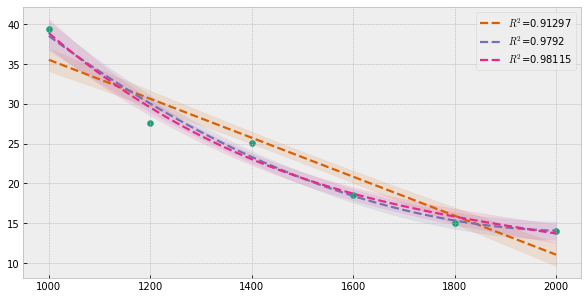

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], pm, fig, ax, cm.Dark2, True, False)

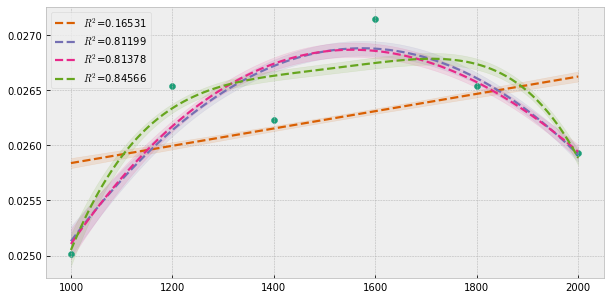

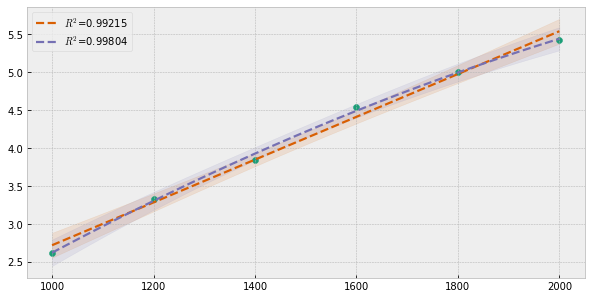

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3,4], df_velocidad['n(rpm)'], Me, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], Ne, fig, ax, cm.Dark2, True, False)

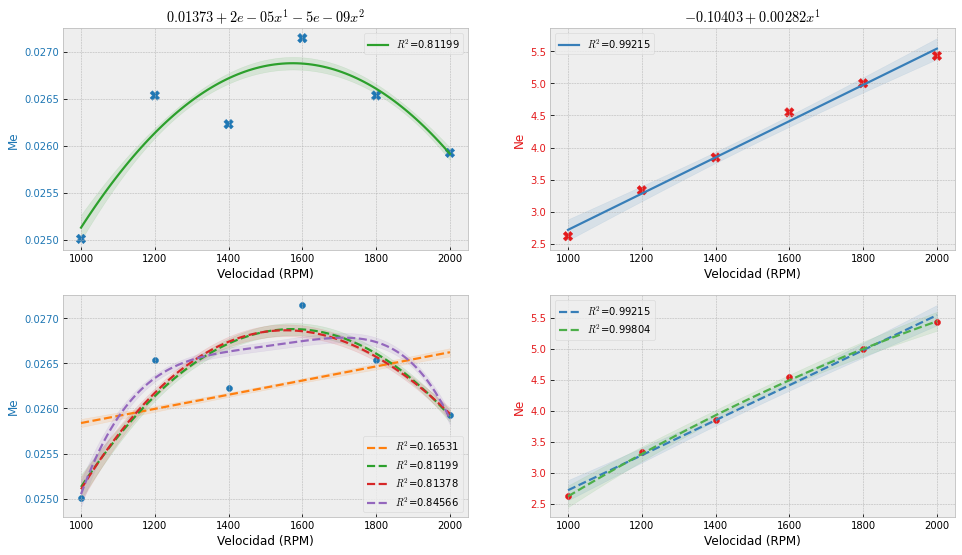

In [7]:
gen_plot([[1,2,3,4], [1,2]], [2, 1], df_velocidad['n(rpm)'], [Me, Ne], 'Velocidad (RPM)', ['Me', 'Ne'])

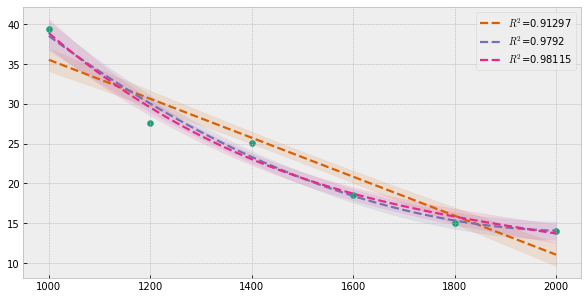

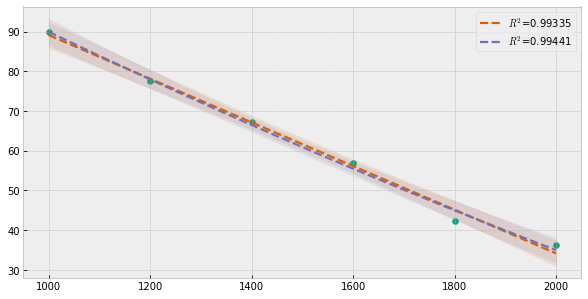

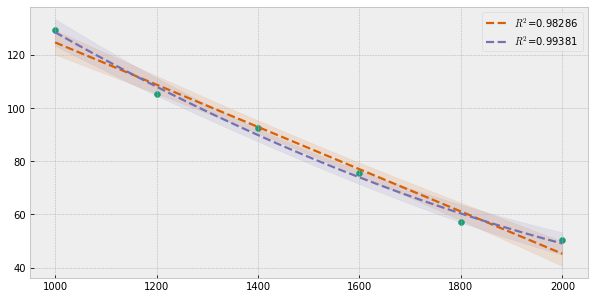

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], pm, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], pe, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], pi, fig, ax, cm.Dark2, True, False)

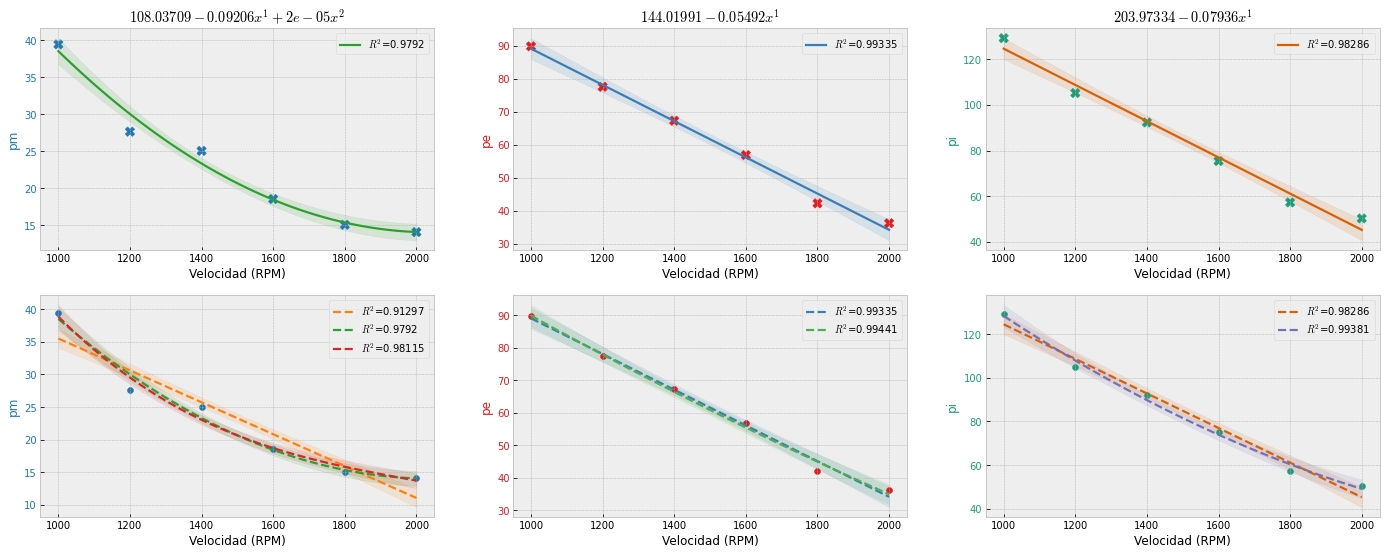

In [9]:
gen_plot([[1,2,3], [1,2], [1,2]], [2, 1, 1], df_velocidad['n(rpm)'], [pm, pe, pi], 'Velocidad (RPM)', ['pm', 'pe', 'pi'])

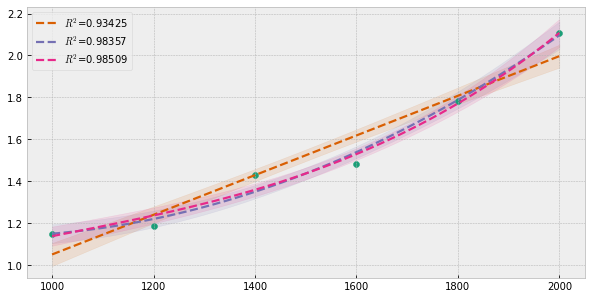

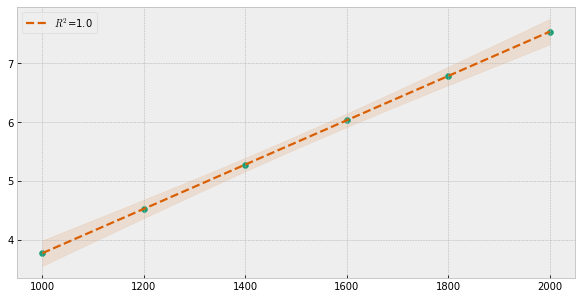

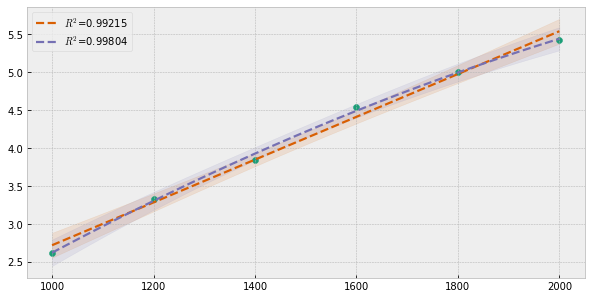

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], Nm, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1], df_velocidad['n(rpm)'], Ni, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], Ne, fig, ax, cm.Dark2, True, False)

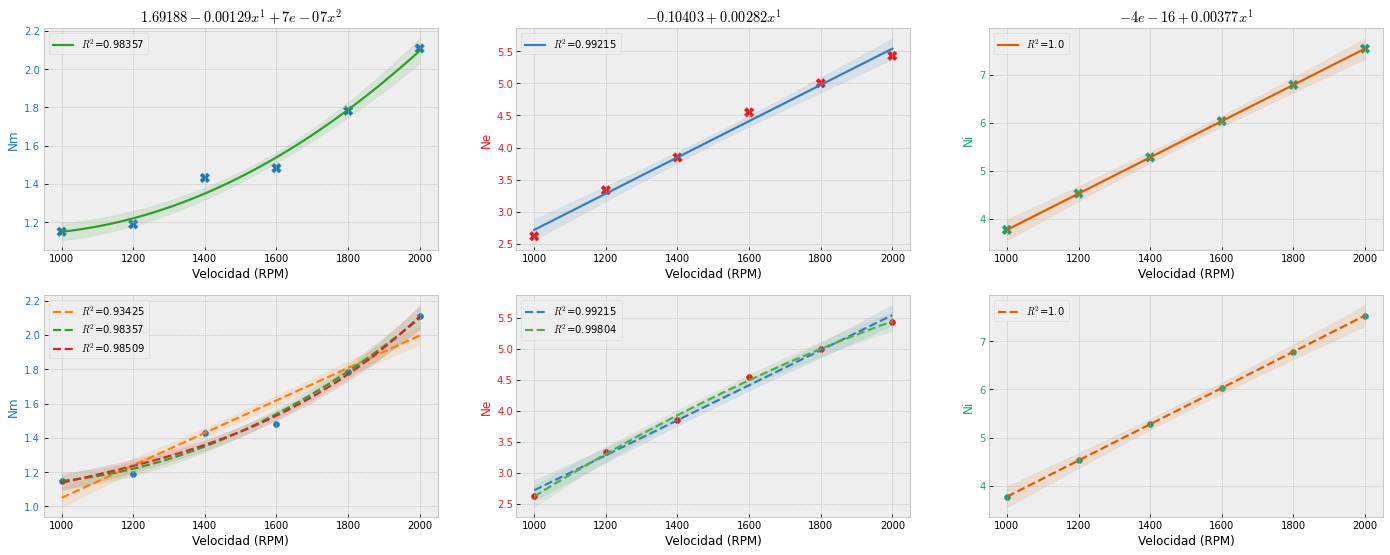

In [11]:
gen_plot([[1,2,3], [1,2], [1]], [2, 1, 1], df_velocidad['n(rpm)'], [Nm, Ne, Ni], 'Velocidad (RPM)', ['Nm', 'Ne', 'Ni'])

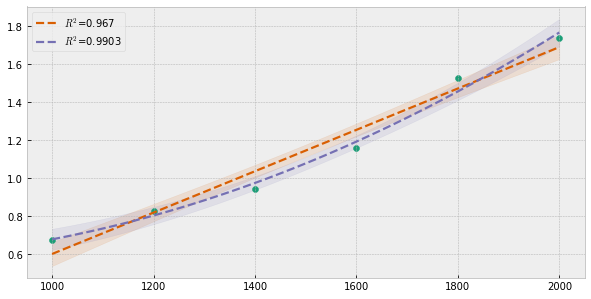

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], df_velocidad['n(rpm)'], Gc, fig, ax, cm.Dark2, True, False)

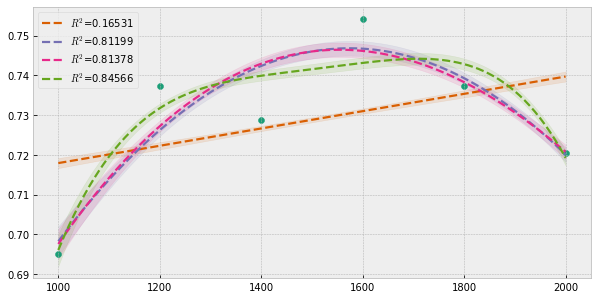

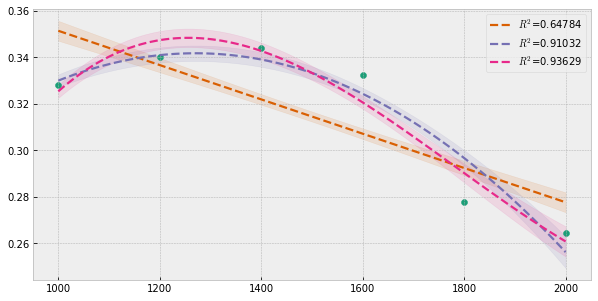

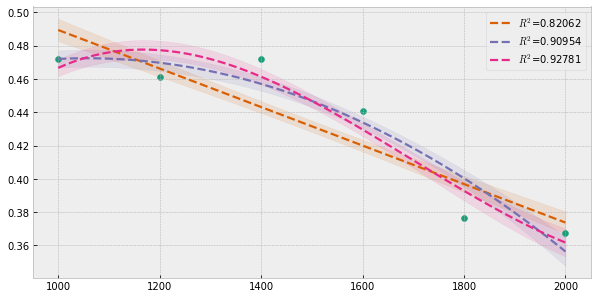

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3,4], df_velocidad['n(rpm)'], eta_m, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], eta_e, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], eta_i, fig, ax, cm.Dark2, True, False)

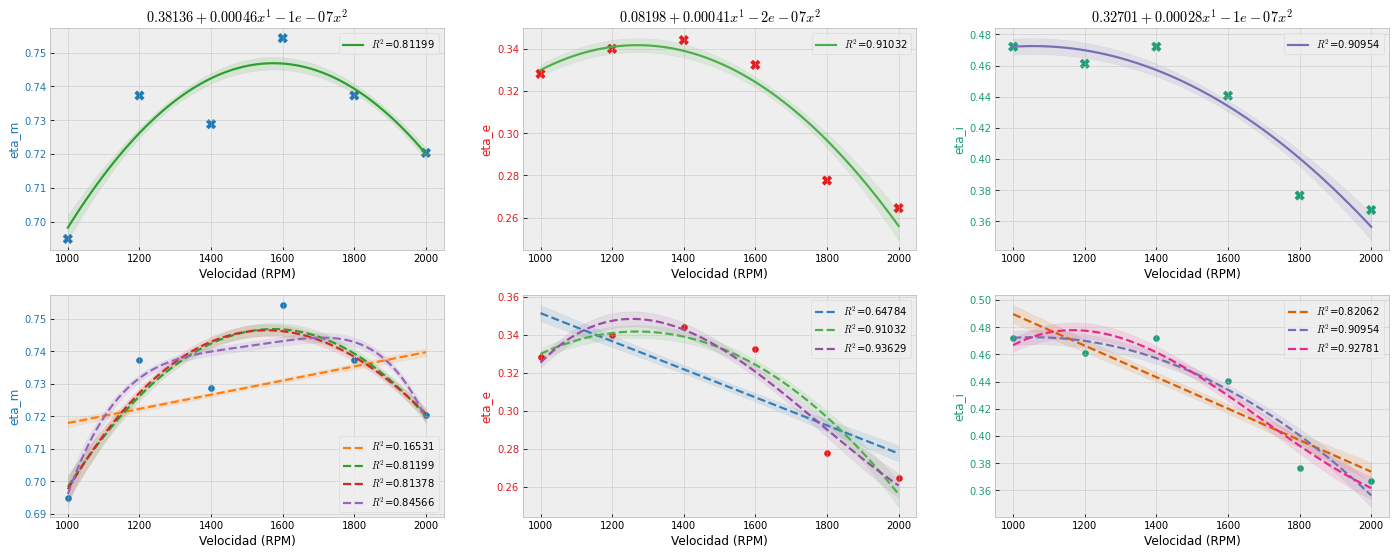

In [14]:
gen_plot([[1,2,3,4], [1,2,3], [1,2,3]], [2, 2, 2], df_velocidad['n(rpm)'], [eta_m, eta_e, eta_i], 'Velocidad (RPM)', ['eta_m', 'eta_e', 'eta_i'])

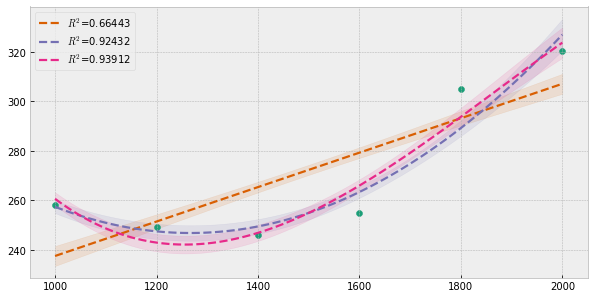

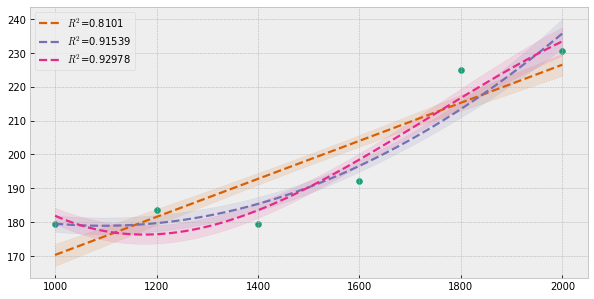

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], ge, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], df_velocidad['n(rpm)'], gi, fig, ax, cm.Dark2, True, False)

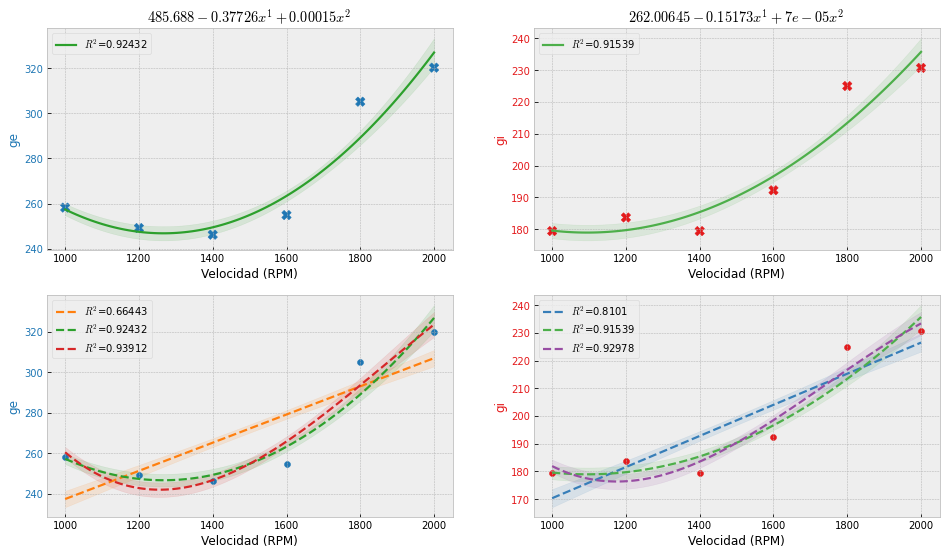

In [16]:
gen_plot([[1,2,3], [1,2,3]], [2, 2], df_velocidad['n(rpm)'], [ge, gi], 'Velocidad (RPM)', ['ge', 'gi'])

# Prueba de carga 1

In [17]:
t = 10 #s
P0 = 1.001 #bar
T0 = 300 #K
n = 1800 #RPM
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
rho_c = 0.805 #kg/L
b = 0.305 #m

df_carga1 = pd.read_csv('/home/heneos/Downloads/carga_1.csv')
df_carga1

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),...,etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,89,10.8,8.1,9.8,4.74,69,72,79.0,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.25,87,10.8,7.5,10.0,4.25,69,72,81.0,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.50,83,10.8,7.1,10.0,2.98,70,72,82.0,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.00,71,11.0,5.7,10.2,0.46,70,72,84.0,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16.50,61,11.0,4.9,10.2,0.30,69,71,85.0,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,17.00,52,11.0,4.4,10.2,0.32,68,71,86.0,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
Fd = df_carga1['F(N)']/1000 #kN
Mm = b*(W0-Fd) #kN-m
Nm = Mm*2*np.pi*n/60 #kW
pm = 120*Nm/(n*df_carga1['V (cm^3)']*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*n/60 #kW

pe = 120*Ne/(n*df_carga1['V (cm^3)']*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_carga1['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh

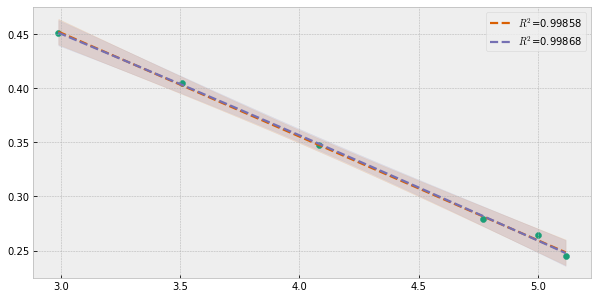

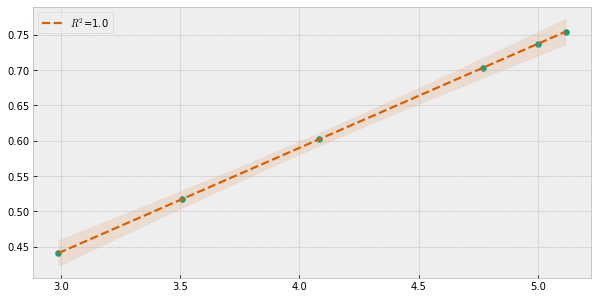

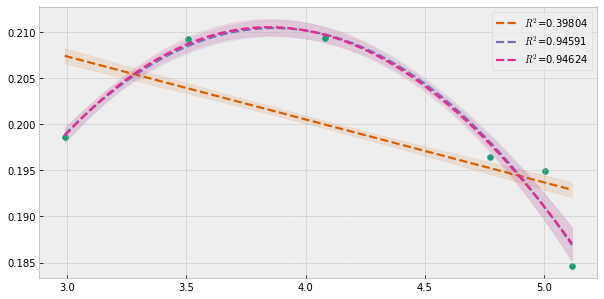

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], Ne, eta_i, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1], Ne, eta_m, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], Ne, eta_e, fig, ax, cm.Dark2, True, False)

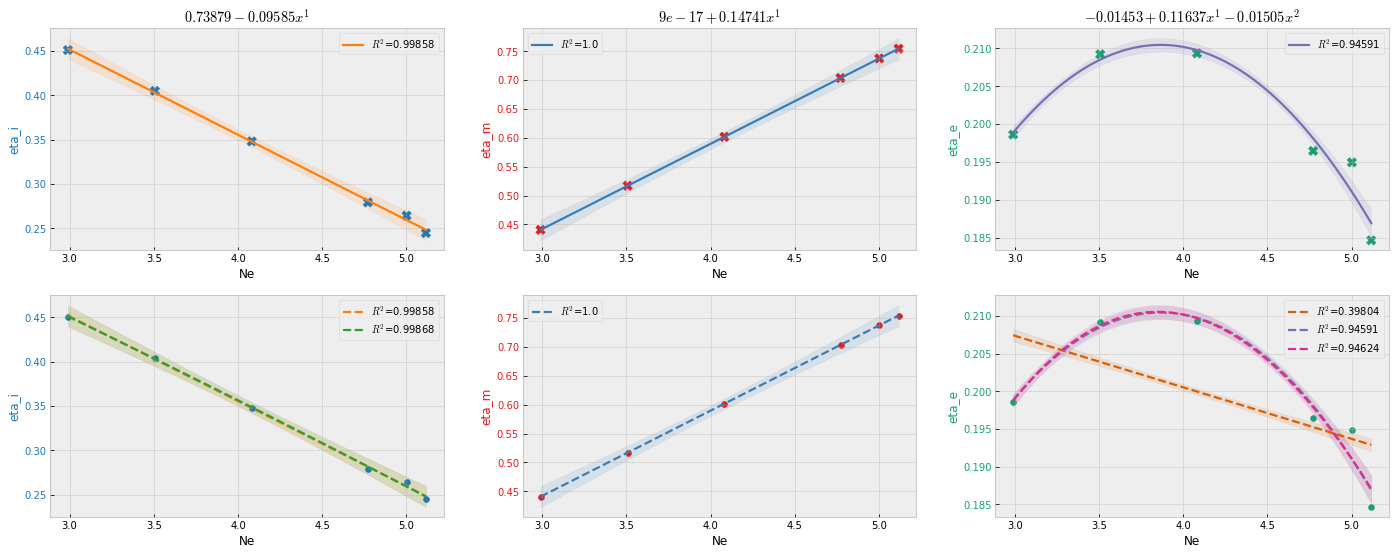

In [20]:
gen_plot([[1,2], [1], [1,2,3]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'])

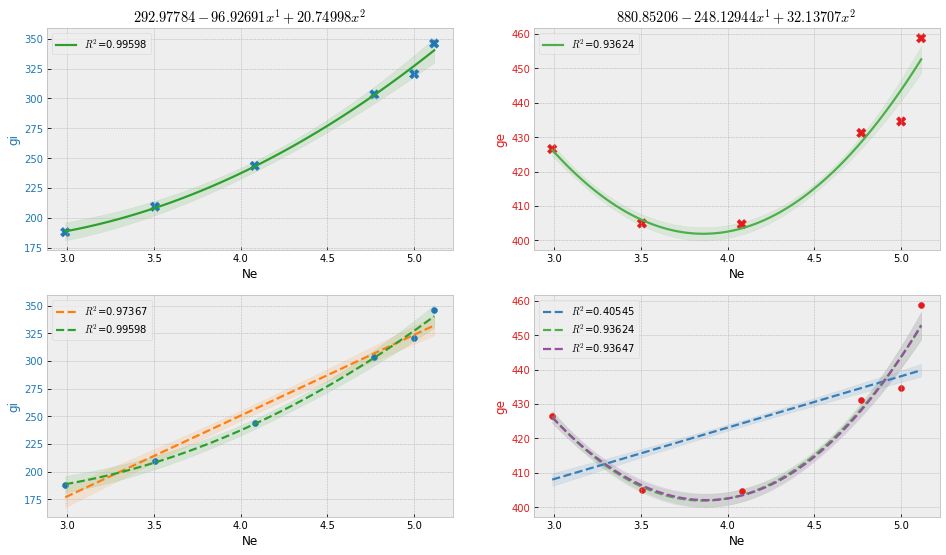

In [21]:
gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'])

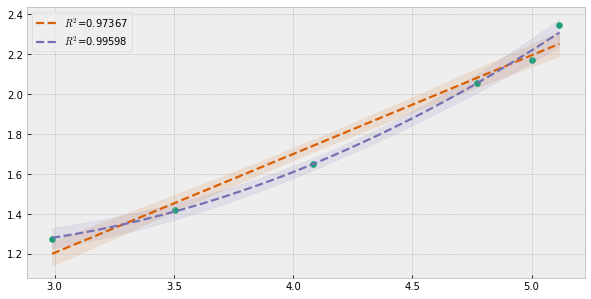

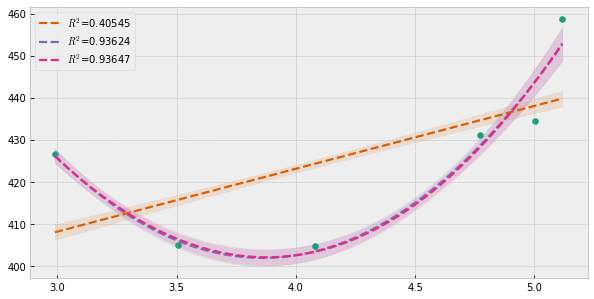

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], Ne, Gc, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], Ne, ge, fig, ax, cm.Dark2, True, False)

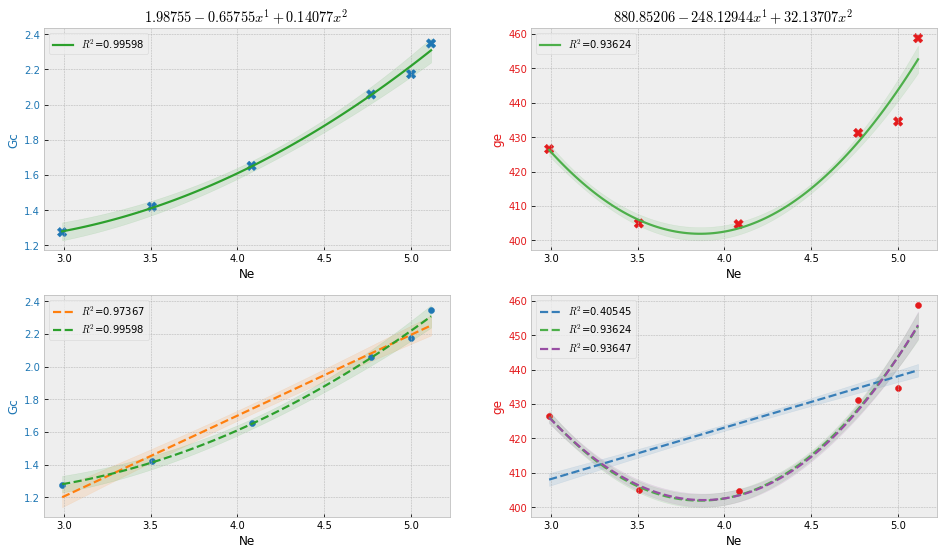

In [23]:
gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'])

# Prueba de carga 2

In [24]:
t = 10 #s
P0 = 1.001 #bar
T0 = 300 #K
n = 1200 #RPM
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
rho_c = 0.805 #kg/L
b = 0.305 #m

df_carga2 = pd.read_csv('/home/heneos/Downloads/carga_2.csv')
df_carga2

,hc(cm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),...,etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,15.00,91,7.3,4.4,6.0,0.97,68,70,81.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.25,86,7.4,4.2,6.1,0.74,70,72,82.0,23.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.50,81,7.3,3.8,6.0,0.49,69,72,82.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.00,66,7.3,3.2,6.1,0.52,69,71,82.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16.50,56,7.4,2.8,6.1,0.51,69,71,82.0,23.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
Fd = df_carga1['F(N)']/1000 #kN
Mm = b*(W0-Fd) #kN-m
Nm = Mm*2*np.pi*n/60 #kW
pm = 120*Nm/(n*df_carga1['V (cm^3)']*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*n/60 #kW

pe = 120*Ne/(n*df_carga1['V (cm^3)']*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_carga1['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh

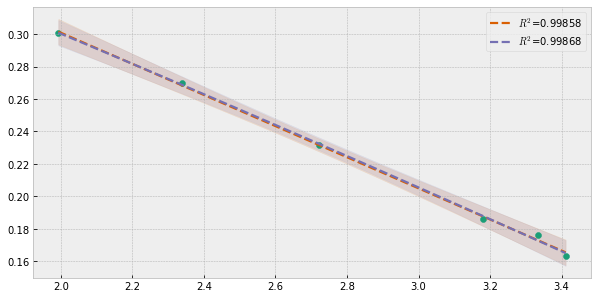

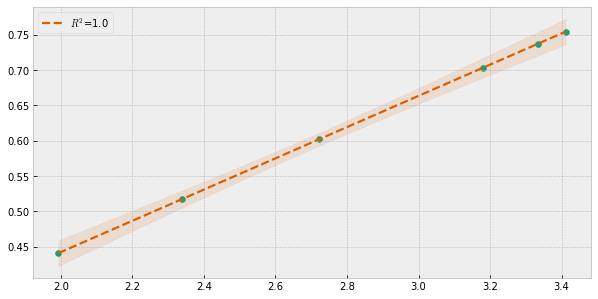

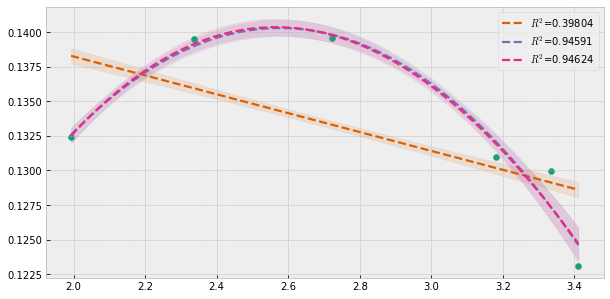

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], Ne, eta_i, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1], Ne, eta_m, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], Ne, eta_e, fig, ax, cm.Dark2, True, False)

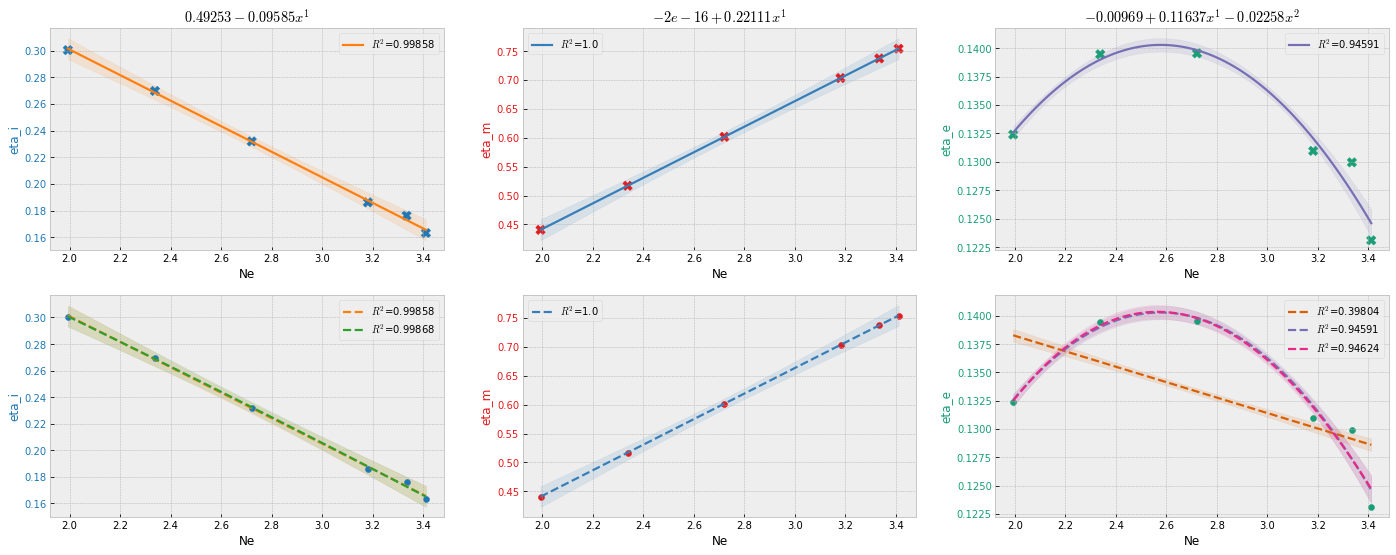

In [27]:
gen_plot([[1,2], [1], [1,2,3]], [1, 1, 2], Ne, [eta_i, eta_m, eta_e], 'Ne', ['eta_i', 'eta_m', 'eta_e'])

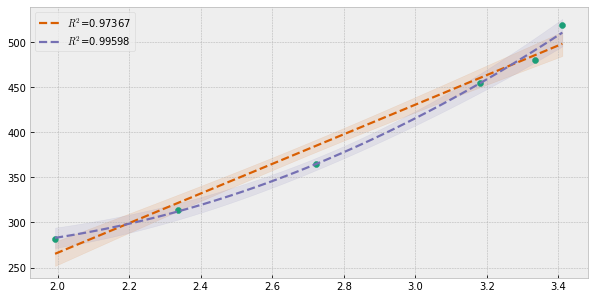

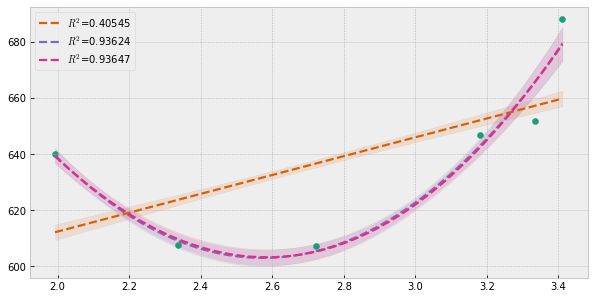

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], Ne, gi, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], Ne, ge, fig, ax, cm.Dark2, True, False)

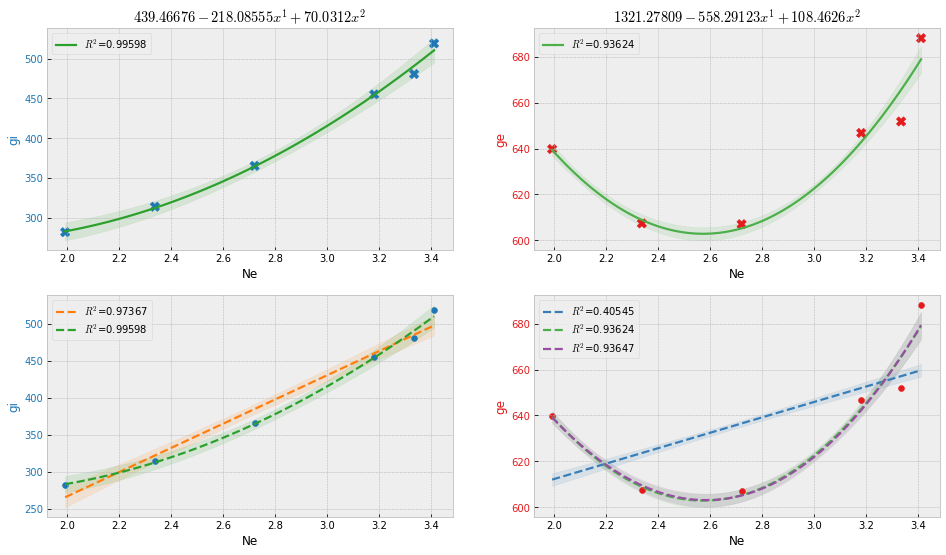

In [29]:
gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [gi, ge], 'Ne', ['gi', 'ge'])

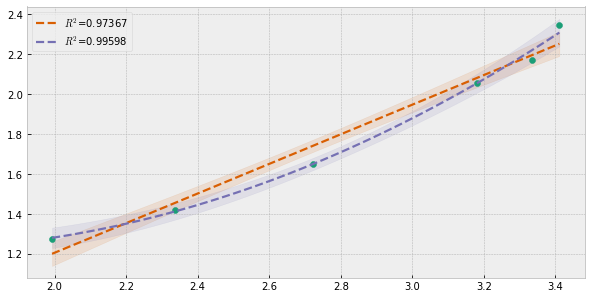

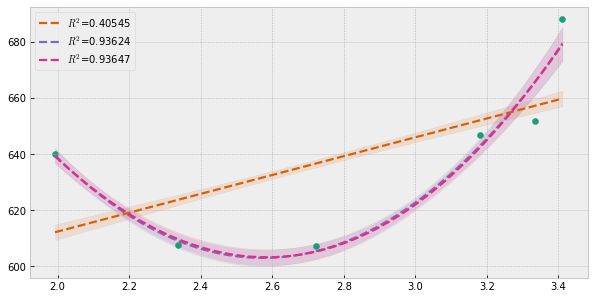

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2], Ne, Gc, fig, ax, cm.Dark2, True, False)
fig, ax = plt.subplots(1,1,figsize=(10,5))
test_plot([1,2,3], Ne, ge, fig, ax, cm.Dark2, True, False)

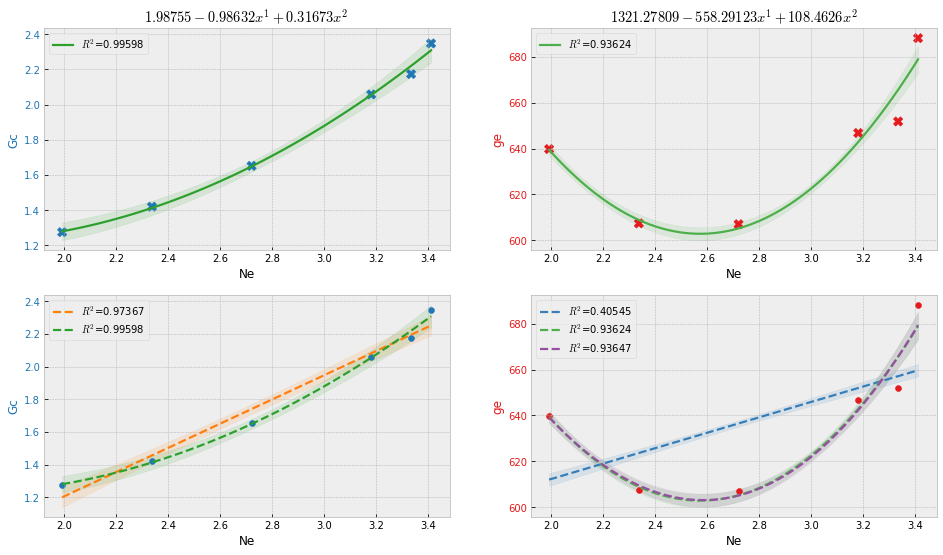

In [31]:
gen_plot([[1,2], [1,2,3]], [2, 2], Ne, [Gc, ge], 'Ne', ['Gc', 'ge'])